# Style Transfer

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras
import h5py
import math
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.layers import *
from keras.applications import vgg19

import tensorflow as tf
import numpy as np
from PIL import Image
from IPython.display import display
from io import BytesIO

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
import ipywidgets as widgets

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Hyperparameters

In [68]:
MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
IMAGE_SIZE = 500
IMAGE_WIDTH = 500
IMAGE_HEIGHT = 500

ITERATIONS = 50
TOTAL_VARIATION_WEIGHT = 1
TOTAL_VARIATION_LOSS_FACTOR = 1.3
CONTENT_WEIGHT = 0.1
STYLE_WEIGHT = 100 - CONTENT_WEIGHT

## Input image

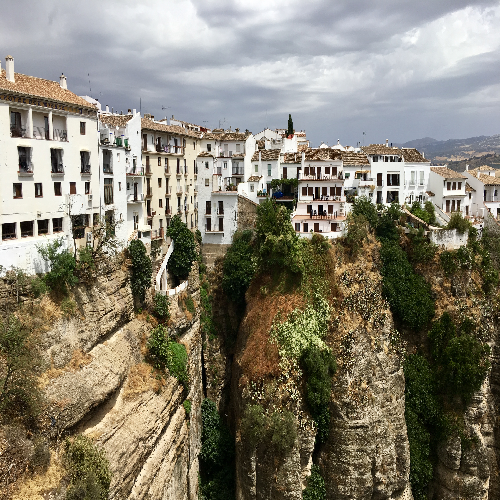

In [84]:
input_image_path = 'data/dlp_input1.jpg'
input_image = Image.open(input_image_path)
input_image = input_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
input_image

## Style image

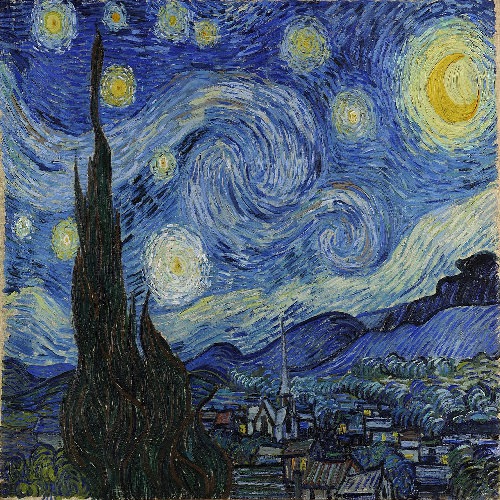

In [85]:
style_image_path = 'data/dlp_style1.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
style_image

## Use Normalization

In [86]:
input_image_array = np.asarray(input_image, dtype = "float32")
input_image_array = np.expand_dims(input_image_array, axis = 0)
input_image_array[:, :, :, 2] -= MEAN_RGB_VALUES[0]
input_image_array[:, :, :, 1] -= MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 0] -= MEAN_RGB_VALUES[2]

input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype = "float32")
style_image_array = np.expand_dims(style_image_array, axis = 0)
style_image_array[:, :, :, 2] -= MEAN_RGB_VALUES[0]
style_image_array[:, :, :, 1] -= MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 0] -= MEAN_RGB_VALUES[2]

style_image_array = style_image_array[:, :, :, ::-1]

## Build VGG16 model

In [87]:
input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)
comb_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

input_t = backend.concatenate([input_image, style_image, comb_image], axis = 0)
model = VGG16(input_tensor = input_t, include_top = False)

## Compute content loss function

In [ ]:
def compute_content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [88]:
# Get list of layers as dictionary
layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
content_layer_features = layers[content_layer]
content_image_features = content_layer_features[0, :, :, :]
comb_features = content_layer_features[2, :, :, :]

loss = backend.variable(0.)
loss += CONTENT_WEIGHT * compute_content_loss(content_image_features, comb_features)

## Gram matrix generation function

In [89]:
def get_gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    
    return gram

## Compute style loss function

In [ ]:
def compute_style_loss(style_features, combination_features):
    style = get_gram_matrix(style_features)
    combination = get_gram_matrix(combination_features)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    
    return backend.sum(backend.square(style - combination)) / (4. * (3 ** 2) * (size ** 2))

In [90]:
layers_for_style = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]

for layer in layers_for_style:
    layer_features = layers[layer]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    
    style_loss = compute_style_loss(style_features, combination_features)
    # Set equal weight for each style layer
    loss += (STYLE_WEIGHT / len(layers_for_style)) * style_loss

In [91]:
def compute_total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

loss += TOTAL_VARIATION_WEIGHT * compute_total_variation_loss(comb_image)

In [ ]:
outputs = [loss]
outputs += backend.gradients(loss, comb_image)

In [92]:
class LossGrad:

    def loss(self, x):
        x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
        out = backend.function([comb_image], outputs)([x])

        loss = out[0]
        gradients = out[1].flatten().astype("float64")
        
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

loss_grad = LossGrad()

In [93]:
def displayImage(image_x, num):
    image_x = image_x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    image_x = image_x[:, :, ::-1]
    image_x[:, :, 2] += MEAN_RGB_VALUES[0]
    image_x[:, :, 1] += MEAN_RGB_VALUES[1]
    image_x[:, :, 0] += MEAN_RGB_VALUES[2]
    image_x = np.clip(image_x, 0, 255).astype("uint8")
    
    output_image = Image.fromarray(image_x)
    output_image.save("output_with_variation_content10_vangogh_correct_%d.png" % num)
    # display(output_image)

In [94]:
def displayResultImage(x):
    x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    x = x[:, :, ::-1]
    x[:, :, 2] += MEAN_RGB_VALUES[0]
    x[:, :, 1] += MEAN_RGB_VALUES[1]
    x[:, :, 0] += MEAN_RGB_VALUES[2]
    x = np.clip(x, 0, 255).astype("uint8")
    
    output_image = Image.fromarray(x)
    output_image.save("test/final_output.png")
    output_image

In [95]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(ITERATIONS):
    x, loss, inf = fmin_l_bfgs_b(loss_grad.loss, x.flatten(), fprime = loss_grad.gradients, maxfun = 25)
    
    print("Iteration: %d - Loss: %d" % (i, loss))
    
    output_x = copy.deepcopy(x)
    displayImage(output_x, i)
    
displayResultImage(x)

Iteration: 0 - Loss: 375654055936
Iteration: 1 - Loss: 163295264768
Iteration: 2 - Loss: 109170622464
Iteration: 3 - Loss: 90686906368
Iteration: 4 - Loss: 83325435904
Iteration: 5 - Loss: 79707906048
Iteration: 6 - Loss: 77057875968
Iteration: 7 - Loss: 75293376512
Iteration: 8 - Loss: 73993396224
Iteration: 9 - Loss: 72995086336
Iteration: 10 - Loss: 72249884672
Iteration: 11 - Loss: 71505108992
Iteration: 12 - Loss: 70914777088
Iteration: 13 - Loss: 70446800896
Iteration: 14 - Loss: 70072434688
Iteration: 15 - Loss: 69740093440
Iteration: 16 - Loss: 69461213184
Iteration: 17 - Loss: 69216747520
Iteration: 18 - Loss: 68998012928
Iteration: 19 - Loss: 68791959552
Iteration: 20 - Loss: 68631724032
Iteration: 21 - Loss: 68489768960
Iteration: 22 - Loss: 68361826304
Iteration: 23 - Loss: 68247089152
Iteration: 24 - Loss: 68145246208
Iteration: 25 - Loss: 68060733440
Iteration: 26 - Loss: 67988811776
Iteration: 27 - Loss: 67924402176
Iteration: 28 - Loss: 67865288704
Iteration: 29 - Loss: